<a href="https://colab.research.google.com/github/slcnvly/REINFORCE-Cartpole/blob/master/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
def plot_learning_curve(scores):
    plt.figure(figsize=(10, 5))

    # 원본 점수 (연한 색으로 배경에 깔기)
    plt.plot(scores, label='Raw Score', color='cyan', alpha=0.3)

    # 이동 평균 (Moving Average) - 추세를 보기 위함
    # 최근 50개 에피소드의 평균을 계산해서 부드러운 선으로 그림
    window_size = 50
    moving_avg = []
    for i in range(len(scores)):
        start_idx = max(0, i - window_size)
        avg = sum(scores[start_idx : i+1]) / (i - start_idx + 1)
        moving_avg.append(avg)

    plt.plot(moving_avg, label=f'Moving Avg ({window_size})', color='blue')

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('A2C Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.0003
gamma = 0.98

class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2) # CartPole Action: 0(왼), 1(오)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # DQN은 그냥 값을 내보냈지만, REINFORCE는 '확률'을 내보내야 함
        prob = F.softmax(x, dim=1)
        return prob

In [4]:
class REINFORCE(nn.Module):
    def __init__(self):
        super(REINFORCE, self).__init__()
        self.model = PolicyNet()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.data = [] # 에피소드 동안의 데이터를 저장할 리스트

    def put_data(self, item):
        # (보상, 로그확률)을 저장
        self.data.append(item)

    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        loss = 0
        G_t = 0

        # G_t를 뒤에서부터 계산
        for r, log_prob in self.data[::-1]:
            G_t += r * (gamma ** R)
            R += 1
            loss += -log_prob * G_t

        loss.backward()
        self.optimizer.step()
        self.data = [] # 학습했으면 데이터를 비워줌 (On-policy)

/tmp/ipython-input-13552276.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s = torch.FloatTensor([s])


Episode: 20 | Score: 29.4
Episode: 40 | Score: 21.5
Episode: 60 | Score: 26.4
Episode: 80 | Score: 24.0
Episode: 100 | Score: 28.3
Episode: 120 | Score: 31.6
Episode: 140 | Score: 26.8
Episode: 160 | Score: 39.1
Episode: 180 | Score: 30.6
Episode: 200 | Score: 33.9
Episode: 220 | Score: 35.1
Episode: 240 | Score: 30.4
Episode: 260 | Score: 42.8
Episode: 280 | Score: 36.2
Episode: 300 | Score: 34.7
Episode: 320 | Score: 42.4
Episode: 340 | Score: 44.8
Episode: 360 | Score: 37.5
Episode: 380 | Score: 52.4
Episode: 400 | Score: 42.5
Episode: 420 | Score: 42.6
Episode: 440 | Score: 60.8
Episode: 460 | Score: 52.0
Episode: 480 | Score: 56.5
Episode: 500 | Score: 50.2
Episode: 520 | Score: 60.3
Episode: 540 | Score: 45.9
Episode: 560 | Score: 73.2
Episode: 580 | Score: 72.1
Episode: 600 | Score: 66.0
Episode: 620 | Score: 61.0
Episode: 640 | Score: 79.4
Episode: 660 | Score: 91.6
Episode: 680 | Score: 93.3
Episode: 700 | Score: 79.2
Episode: 720 | Score: 86.0
Episode: 740 | Score: 106.7
Epis

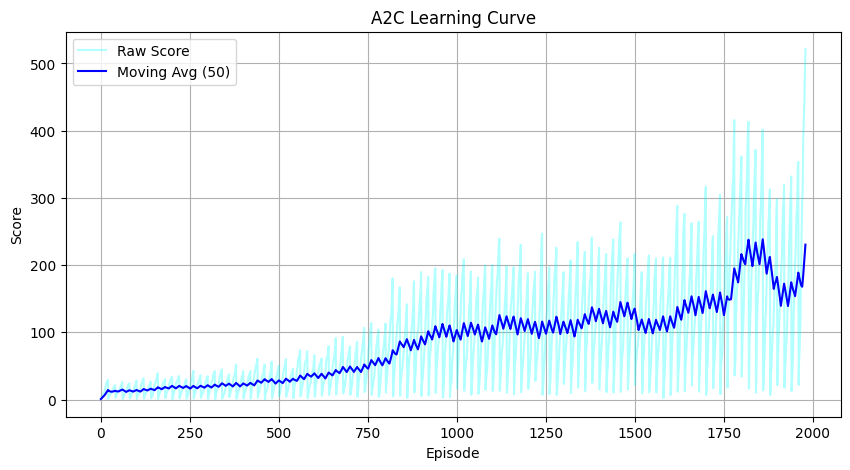

In [5]:
def main():
    env = gym.make('CartPole-v1')
    agent = REINFORCE()
    score = 0.0
    scores = []

    for n_epi in range(10000):
        s, _ = env.reset()
        done = False

        while not done:
            # =확률 분포(Categorical)를 이용해 샘플링
            s = torch.FloatTensor([s])
            probs = agent.model(s)
            m = Categorical(probs)
            a = m.sample()
            log_prob = m.log_prob(a)

            s_prime, r, done, truncated, _ = env.step(a.item())
            # 나중에 계산할 때 필요한 '보상'과 '우리가 선택한 확률의 로그값'만 저장
            agent.put_data((r, log_prob))

            s = s_prime
            score += r

            if done:
                break
        scores.append(score/20.0)
        # DQN은 while문 안에서 학습했지만, REINFORCE는 에피소드가 끝나야 학습
        agent.train_net()

        if n_epi % 20 == 0 and n_epi != 0:
            print(f"Episode: {n_epi} | Score: {score/20.0:.1f}")

            if score/20.0 >= 500.0:
                print(f"mission complete on Episode {n_epi}! terminate learning.")
                plot_learning_curve(scores)
                break
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()